<a href="https://colab.research.google.com/github/higebobo/my-colab/blob/main/fisco_stock_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 出来た株・動いた株

* [出来た株・動いた株](https://market.fisco.co.jp/update/analysis/kabu.jsp)
* [【Python】Google ColaboratoryでSelenium実行｜ゆゆうブログ](https://yuyuublog.com/colaboratoryselenium/)
* [python \- WebDriverException: Message: Service /usr/lib/chromium\-browser/chromedriver unexpectedly exited on Raspberry\-Pi with ChromeDriver and Selenium \- Stack Overflow](https://stackoverflow.com/questions/49796818/webdriverexception-message-service-usr-lib-chromium-browser-chromedriver-unex)
* [Issues when trying to use Chromedriver in Colab · Issue \#3347 · googlecolab/colabtools](https://github.com/googlecolab/colabtools/issues/3347)

## 改定履歴

* 2023/1/19 ubuntuのバージョンが上がったせいかchrome-driverの挙動が変わった
* 2022/12/21 pandas_datareaderがyahooからデータ取得できなくなったのでyfinanceに入れ替え
* 2022/11/28 初版

## Text version

### Install

[Issues when trying to use Chromedriver in Colab · Issue \#3347 · googlecolab/colabtools](https://github.com/googlecolab/colabtools/issues/3347)

In [14]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

Executing: /tmp/apt-key-gpghome.I4xBweJzmK/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.mFLgbLH73t/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.mRwefj0zvz/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
gpg: cannot open '/dev/tty': No such device or address
gpg: [stdout]: write error: Broken pipe
gpg: filter_flush failed on c

### Import

In [15]:
import re

from IPython.display import HTML, display
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

### Define variables

In [16]:
wait = 1
url = 'https://market.fisco.co.jp/update/analysis/kabu.jsp'

pattern = '\*(.+)<(\d+)>\s(\d+)\s(.+\d+)\n(.+)'
rc = re.compile(pattern, re.MULTILINE | re.DOTALL)

# yahoo finance
stock_base_url = 'https://finance.yahoo.co.jp/quote/'

### Initialize

In [17]:
options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.headless = True
service = Service(executable_path='/usr/bin/chromedriver')

driver = webdriver.Chrome(service=service, options=options)
driver.implicitly_wait(wait)

### Get data

In [18]:
driver.get(url)

elem = driver.find_element(By.ID, 'ugodeki_uptime')
date_text = elem.text

elem = driver.find_element(By.ID, 'ugodeki')

word_list = re.findall(pattern, elem.text)

### Add information and sort

In [19]:
word_list_updated = list()

for x in word_list:
    if x[3].startswith('+'):
        color = '#090'
        ratio = float(x[3]) / (float(x[2]) - float(x[3])) * 100
    elif x[3].startswith('-'):
        color = '#900'
        ratio = float(x[3]) / (float(x[2]) - float(x[3])) * 100
    else:
        color = '#000'
        ratio = 0
    word_list_updated.append(x + (color, ratio))

word_list_updated.sort(key=lambda x: x[6], reverse=True)

### Output

In [20]:
output = '<h1>(フィスコ)出来た株・動いた株</h1>'
output += f'<h2>{date_text}</h2>'

output += '''
<table>
  <thead>
    <tr>
      <th>コード</th>
      <th>銘柄</th>
      <th>株価</th>
      <th colspan="2">変動価格</th>
      <th>コメント</th>
    </tr>
  </thead>
  <tfoot></tfoot>
  <tbody>
'''

for x in word_list_updated:
    output += f'''
        <tr>
          <td><a href="{stock_base_url}{x[1]}.T" target="_blank">{x[1]}</a></td>
          <td>{x[0]}</td>
          <td style="text-align: right;">{int(x[2]):,}円</td>
          <td style="color: {x[5]}; text-align: right">{x[3]}円</td>
          <td style="color: {x[5]}; text-align: right">{x[6]:1.2f}%</td>
          <td>{x[4]}</td>
        </tr>
    '''

output += '''
  </tbody>
</table>
'''
display(HTML(output))

## Chart version

### Install section

In [21]:
!pip install mplfinance yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uni

### Import section

In [22]:
import base64
import datetime
from io import BytesIO

import mplfinance as mpf
import yfinance as yf

### Basic settings

In [23]:
# Interval
# 本日まで(時差があるので補正)
end = datetime.date.today() + datetime.timedelta(days=1)
# start = end - datetime.timedelta(weeks=26) # 6 month
start = end - datetime.timedelta(weeks=26*2) # 1 year
# start = end - datetime.timedelta(weeks=26*4) # 2 year
# start = end - datetime.timedelta(weeks=26*10) # 5 year

params = {'start': start, 'end': end}

## 期間指定する場合
# 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
period = '3mo'

params = {'period': period}

### Output

**NOTE: It takes about 30 seconds**

**注意: 処理時間が30秒近くかかる**

銘柄情報,チャート
2334 イオレ 1570円 +268円(20.58%) 短期資金の関心向かう。,
3896 阿波製紙 510円 +80円(18.60%) 逆浸透膜用支持体の新工場建設を引き続き期待材料視。,
5246 ＥＬＥＭＥＮＴＳ 532円 +80円(17.70%) 東証が信用取引の規制解除、日証金も増担保措置解除。,
7084 キッズスマイル 1105円 +150円(15.71%) 岸田首相が施政方針演説で「子育て政策」を「最重要政策」と,
6567 ＳＥＲＩＯホールディングス 736円 +83円(12.71%) 岸田首相の施政方針演説の原案伝わり、関心継続か。,
6181 タメニー 112円 +11円(10.89%) 結婚相談所の入会資格を20歳以上に拡大。,
7359 東京通信 1367円 +125円(10.06%) インセンティブゲームがApp Storeランキングで1位。,
7037 テノ． 643円 +56円(9.54%) 岸田首相は「こども・子育て政策」を最重要政策と位置づけ。,
3810 サイバーステップ 546円 +37円(7.27%) 積極的な提携策などを引き続き評価へ。,
4481 ベース 4090円 +265円(6.93%) 業績・配当予想を上方修正。,

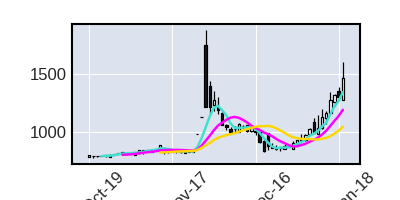
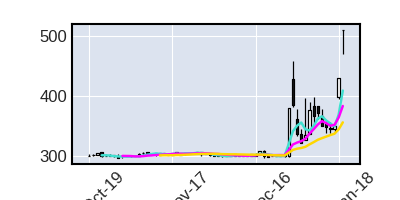
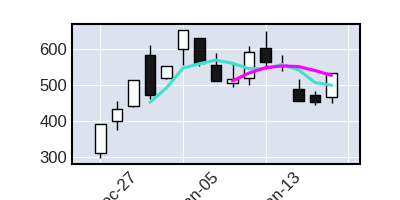
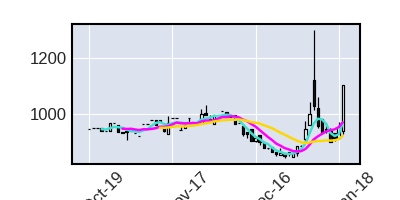
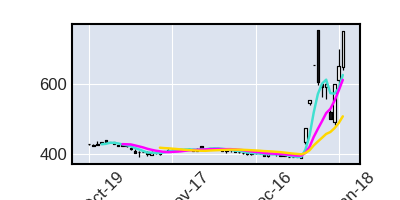
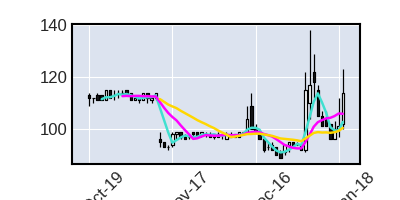
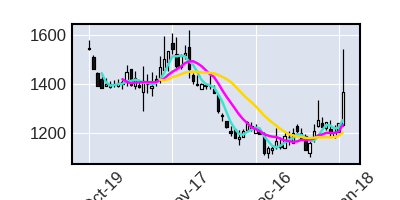
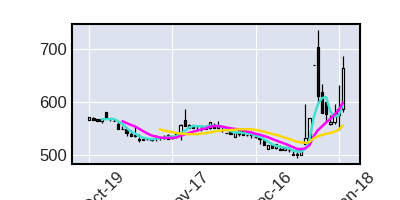
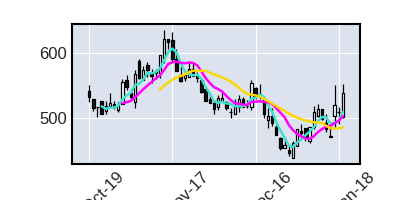
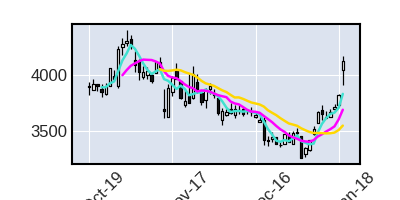
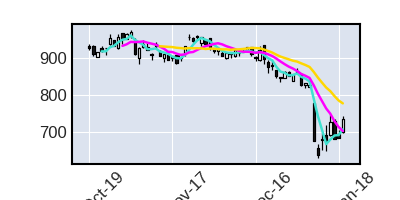
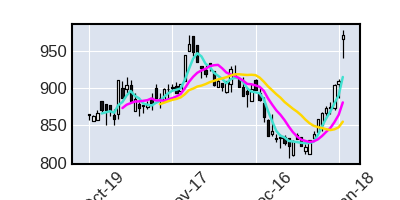
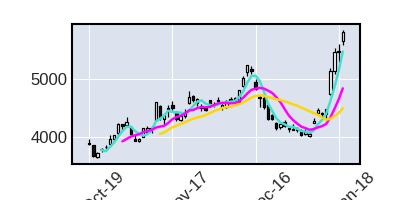
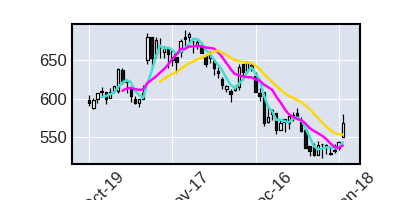
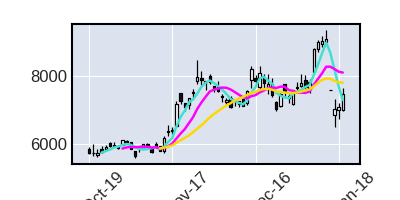
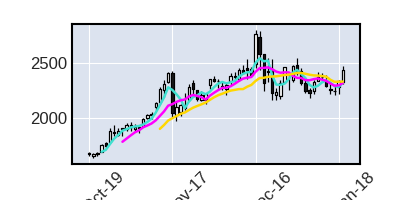
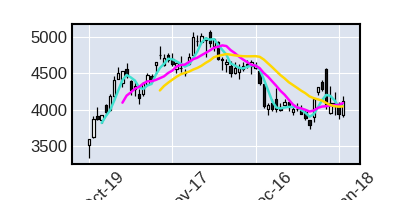
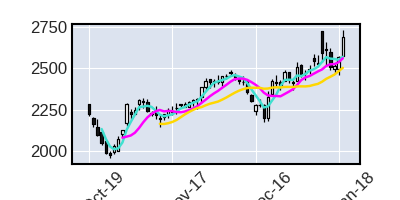
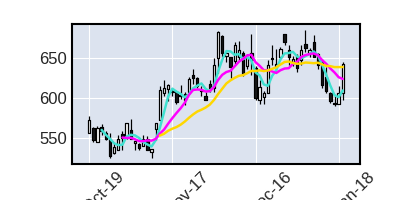
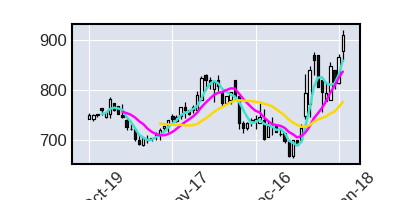
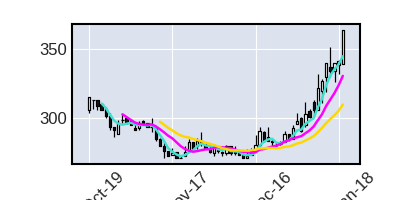
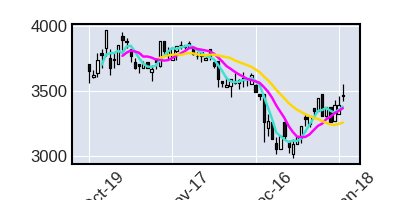
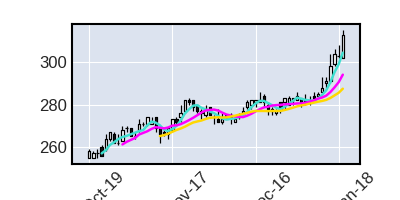
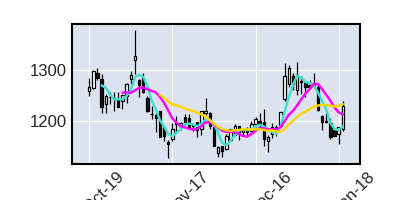
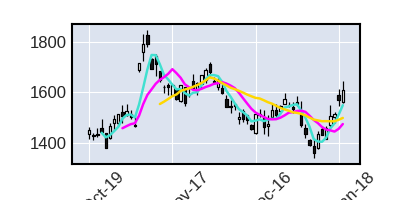
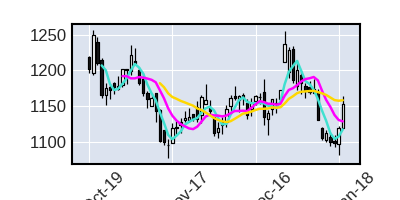
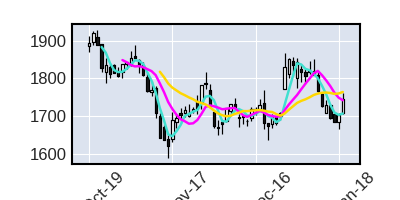
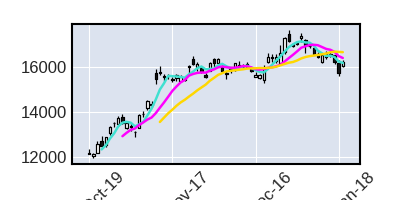
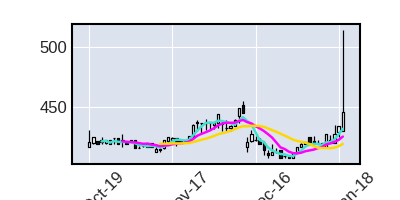
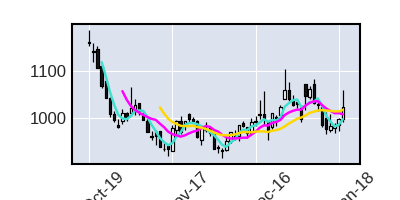
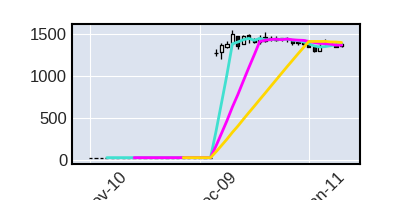
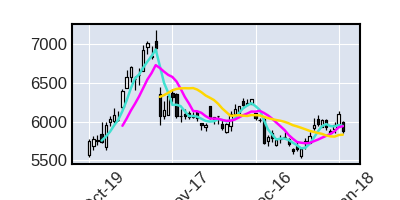
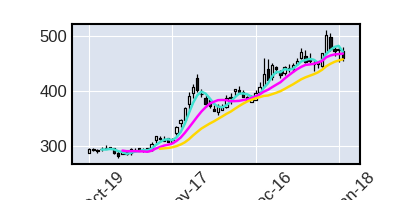
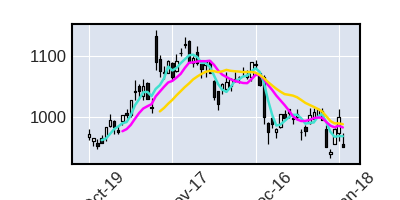
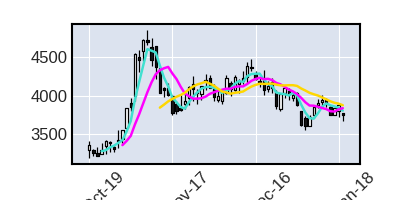
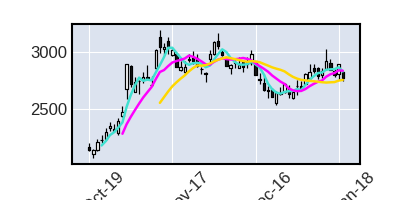
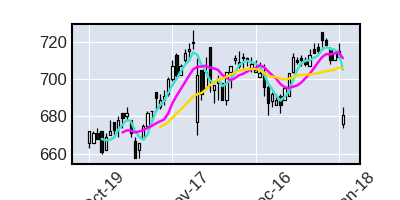
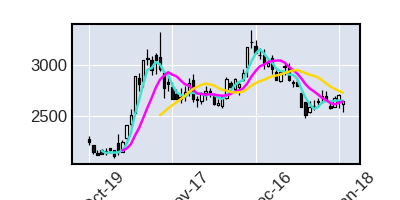
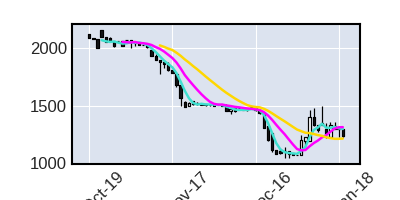
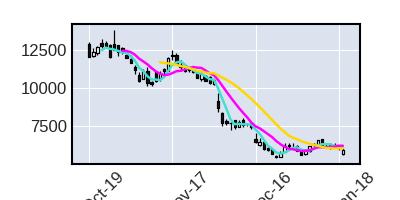
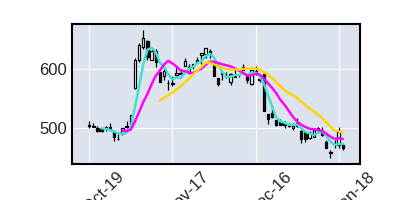
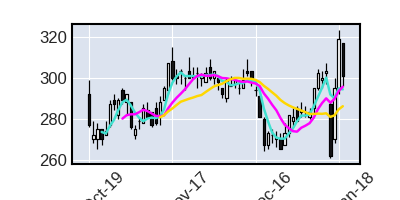
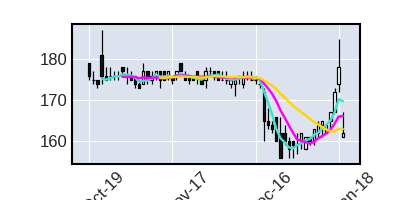

In [24]:
output = '<h1>(フィスコ)出来た株・動いた株</h1>'
output += f'<h2>{date_text}</h2>'

output += '''
<table>
  <thead>
    <tr>
      <th>銘柄情報</th>
      <th>チャート</th>
    </tr>
  </thead>
  <tfoot></tfoot>
  <tbody>
'''

for x in word_list_updated:
    symbol = f'{x[1]}.T'
    stock_url = f'{stock_base_url}{symbol}'
    chart_url = f'{stock_url}/chart'
    
    df = yf.download(symbol, progress=False, **params)
    buffer = BytesIO()
    mpf.plot(df, type='candle', figsize=(4, 2), xlabel='', ylabel='', mav=(4, 9, 18), savefig=buffer)
    img = base64.b64encode(buffer.getvalue()).decode("ascii")

    output += f'''
        <tr>
          <td>
            <ul>
              <li><a href="{stock_url}" target="_blank">{x[1]}&nbsp;{x[0]}</a></li>
              <li>{x[2]}円&nbsp;<span style="color: {x[5]}">{x[3]}円({x[6]:1.2f}%)</span></li>
              <li>{x[4]}</li>
            </ul>            
          </td>
          <td><a href="{chart_url}" target="_blank"><img src="data:image/png;base64,{img}" /></a></td>
        </tr>
    '''
output += '''
  </tbody>
</table>
'''
display(HTML(output))